# Часть 1. Исследовательский анализ данных


In [5]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

In [6]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Пути к датасетам

In [7]:
AIRLINE_STATS_CSV = DATA / 'airline_stats.csv'
KC_TAX_CSV = DATA / 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA / 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA / 'dfw_airline.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
STATE_CSV = DATA / 'state.csv'

## Оценка местоположения
### Оценки местоположения населения и уровня убийств

In [8]:
# Table 1-2
state = pd.read_csv(STATE_CSV)
print(state.head(8))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE


Вычислю среднее, усеченное среднее и медиану для населения. Для среднего и медианы могу использовать методы `pandas`. Для усеченного среднего требуется функция `trim_mean` в `scipy.stats`. 


In [9]:
print(state['Population'].mean())

#trim=0.1 отбрасывает по 10% с каждого конца
print(trim_mean(state['Population'], 0.1))

print(state['Population'].median())



6162876.3
4783697.125
4436369.5


In [10]:
print(np.average(state['Murder.Rate'], weights=state['Population']))

4.445833981123393


In [11]:
print(wquantiles.median(state['Murder.Rate'], weights=state['Population']))

4.4


## Оценки изменчивости

In [12]:
# Table 1-2
print(state.head(10))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE
8      Florida    18801310          5.8           FL
9      Georgia     9687653          5.7           GA


`pandas` предоставляет методы для вычисления **стандартного отклонения и квантилей**. Используя квантили, можно легко определить межквартильный размах (IQR). Для робастной оценки медианного абсолютного отклонения (MAD) использую функцию `robust.scale.mad` из пакета `statsmodels`:

In [13]:
#sd
print(state['Population'].std())
#difference of the 75% and 25% quantile
print(state['Population'].quantile(0.75) - state['Population'].quantile(0.25))
#MAD
print(robust.scale.mad(state['Population']))

6848235.347401142
4847308.0
3849876.1459979336


## Перцентили и боксплоты

In [14]:
print(state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64


In [15]:
# Table 1.4
percentages = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(state['Murder.Rate'].quantile(percentages))
df.index = [f'{p * 100}%' for p in percentages]
print(df.transpose())

             5.0%  25.0%  50.0%  75.0%  95.0%
Murder.Rate   1.6  2.425    4.0   5.55   6.51


Медиана равна 4 убийствам на 100 тыс. человек, несмотря на то что присутствует довольно большая вариабельность: 5-й процентиль составляет всего 1.6, тогда как 95-й процентиль — 6.51.

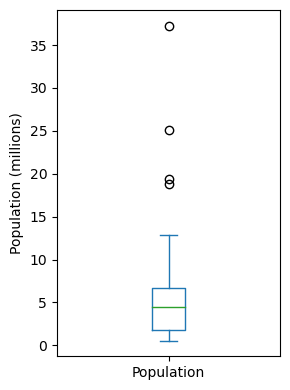

In [16]:
ax = (state['Population']/1_000_000).plot.box(figsize=(3, 4))
ax.set_ylabel('Population (millions)')

plt.tight_layout()
plt.show()

Из этой коробчатой диаграммы мы сразу видим, что медианная численность населения штатов составляет около 5 млн человек, половина штатов приходится на численность от 2 до 7 млн, и существуют некоторые выбросы с высоким населением. Верхняя и нижняя части боксплота — это соответственно 75-й и 25-й процентили. Медиана показана горизонтальной линией в прямоугольнике. 

## Частотная таблица и гистограмма

Метод `cut` для данных `pandas` разбивает набор данных на ячейки. Следующий код создает корзины (бины) одинакового размера. Метод `value_counts` возвращает таблицу частот.

In [17]:
binnedPopulation = pd.cut(state['Population'], 10)
print(binnedPopulation.value_counts())

(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: Population, dtype: int64


Важно учитывать пустые корзины; тот факт, что в этих корзинах значения отсутствуют, является полезной информацией. Возможно также будет полезно поэкспериментировать с разными размерами корзин. Если они слишком крупные, то важные признаки распределения могут быть **затушеваны**. Если же они слишком малые, то результат будет слишком **гранулярным**, и возможность наблюдать общую картину будет потеряна.


In [18]:
# Table 1.5
binnedPopulation.name = 'binnedPopulation'
df = pd.concat([state, binnedPopulation], axis=1)
df = df.sort_values(by='Population')

groups = []
for group, subset in df.groupby(by='binnedPopulation'):
    groups.append({
        'BinRange': group,
        'Count': len(subset),
        'States': ','.join(subset.Abbreviation)
    })
print(pd.DataFrame(groups))

                   BinRange  Count  \
0    (526935.67, 4232659.0]     24   
1    (4232659.0, 7901692.0]     14   
2   (7901692.0, 11570725.0]      6   
3  (11570725.0, 15239758.0]      2   
4  (15239758.0, 18908791.0]      1   
5  (18908791.0, 22577824.0]      1   
6  (22577824.0, 26246857.0]      1   
7  (26246857.0, 29915890.0]      0   
8  (29915890.0, 33584923.0]      0   
9  (33584923.0, 37253956.0]      1   

                                              States  
0  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...  
1          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA  
2                                  VA,NJ,NC,GA,MI,OH  
3                                              PA,IL  
4                                                 FL  
5                                                 NY  
6                                                 TX  
7                                                     
8                                                     
9                              

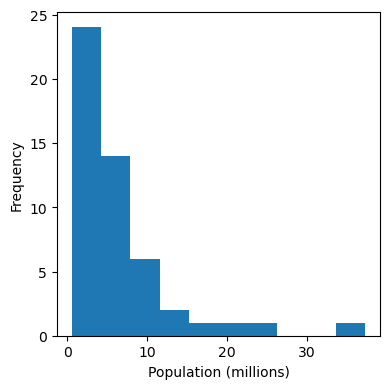

In [19]:
ax = (state['Population'] / 1_000_000).plot.hist(figsize=(4, 4))
ax.set_xlabel('Population (millions)')

plt.tight_layout()
plt.show()

С гистограммой связан *график плотности*, который показывает распределение значений данных в форме сплошной линии. График плотности можно рассматривать как сглаженную гистограмму, несмотря на то что он обычно вычисляется непосредственно из данных посредством *ядерной оценки плотности*.

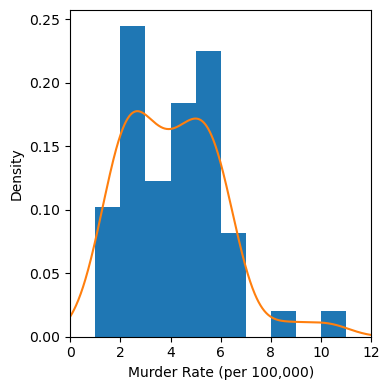

In [20]:
ax = state['Murder.Rate'].plot.hist(density=True, xlim=[0, 12], 
                                    bins=range(1,12), figsize=(4, 4))
state['Murder.Rate'].plot.density(ax=ax)
ax.set_xlabel('Murder Rate (per 100,000)')

plt.tight_layout()
plt.show()

## Изучение двоичных и категориальных данных

In [21]:
# Table 1.6
dfw = pd.read_csv(AIRPORT_DELAYS_CSV)
print(100 * dfw / dfw.values.sum())

     Carrier        ATC   Weather  Security    Inbound
0  23.022989  30.400781  4.025214  0.122937  42.428079


в табл. 1.6 показан процент задержанных рейсов из-за проблем в аэропорту Даллас/Форт-Уэрт, начиная с 2010 года. Задержки распределены по категориям в силу факторов, связанных с перевозчиком (Carrier), системными задержками при управлении воздушным движением (ATC), погодных условий (Weather), соображений безопасности (Security) или опоздания прибывающего воздушного судна (Inbound).

На рис. 1.5 показаны годичные задержки авиарейсов из-за проблем в аэропорту Даллас/Форт-Уэрт

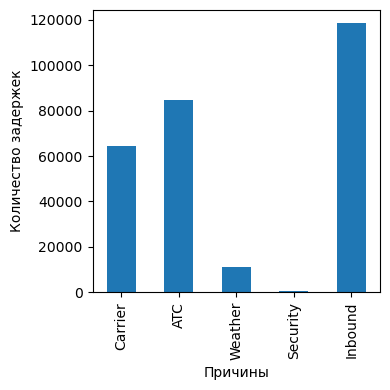

In [22]:
ax = dfw.transpose().plot.bar(figsize=(4, 4), legend=False)
ax.set_xlabel('Причины')
ax.set_ylabel('Количество задержек')

plt.tight_layout()
plt.show()

## Изучение двух или более переменных

рассмотрим набор данных kc_tax, который содержит налогооблагаемую стоимость жилой недвижимости в округе Кинг, штат Вашингтон. Для того чтобы сосредоточиться на главной части данных, мы исключим очень дорогое жилье, а также жилье очень малых или очень больших размеров при помощи функции subset:

In [23]:
kc_tax = pd.read_csv(KC_TAX_CSV)
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000) & 
                     (kc_tax.SqFtTotLiving > 100) &
                     (kc_tax.SqFtTotLiving < 3500), :]
print(kc_tax0.shape)

(432693, 3)


## График с сеткой из шестиугольных корзин

Если количество точек данных становится большим, диаграммы рассеяния теряют смысл. Здесь более полезны методы, визуализирующие плотности. Метод hexbin для pandas — один из мощных подходов.

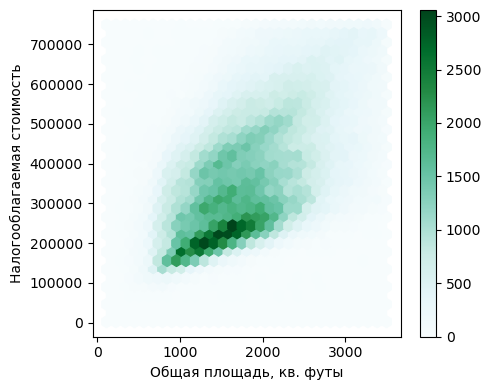

In [24]:
ax = kc_tax0.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue',
                         gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel('Общая площадь, кв. футы')
ax.set_ylabel('Налогооблагаемая стоимость')

plt.tight_layout()
plt.show()

## Категориальные и числовые данные

Коробчатые диаграммы являются простым способом визуального сравнения распределений числовой переменной, сгруппированной согласно категориальной переменной. Например, нам нужно сравнить, каким образом процент задержек авиарейсов варьируется среди авиакомпаний. 

In [28]:
airline_stats = pd.read_csv(AIRLINE_STATS_CSV)
airline_stats.tail(10)
#ax = airline_stats.boxplot(by='airline', column='pct_carrier_delay',figsize=(5, 5))
#ax.set_xlabel('')
#ax.set_ylabel('Daily % of Delayed Flights')
#plt.suptitle('')

#plt.tight_layout()
#plt.show()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
33458,6.950704,1.570423,0.394366,Southwest
33459,5.026423,2.051829,0.052846,Southwest
33460,8.566327,2.022959,0.209184,Southwest
33461,7.188889,3.113889,0.000000,Southwest
33462,9.246445,1.938389,0.000000,Southwest
33463,6.186422,8.798491,1.651940,Southwest
33464,9.522167,3.591133,0.261084,Southwest
33465,9.164179,2.664179,0.343284,Southwest
33466,5.152293,1.964520,0.122817,Southwest
33467,3.964393,1.700479,0.019449,Southwest


На рис. 1.10 отображен процент задержанных авиарейсов за месяц, где задержка была вызвана перевозчиком.

**Авиакомпания Alaska Airlines выделяется тем, что имеет наименьшее число задержек авиарейсов, тогда как American Airlines имеет подавляющее число задержек: нижний квартиль для American Airlines выше верхнего квартиля для Alaska Airlines.**

### Визуализация нескольких переменных

Налогооблагаемая стоимость против общей площади в квадратных футах по почтовому индексу

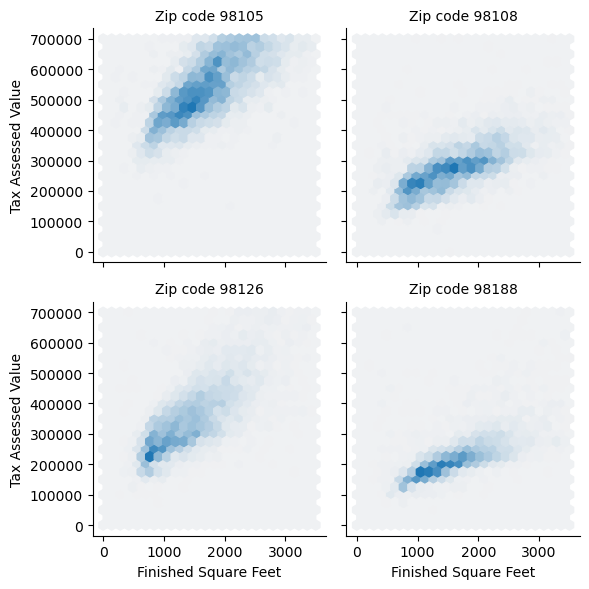

In [26]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes),:]
kc_tax_zip

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', 
      extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax Assessed Value')
g.set_titles('Zip code {col_name:.0f}')

plt.tight_layout()
plt.show()